# Loss Landscape Comparison: ResNet vs DenseNet vs No-Skip

## Objectif
Comparer les loss landscapes de différentes architectures pour comprendre l'impact de:
- **Skip connections** (ResNet & DenseNet vs VGG)
- **Profondeur** (ResNet18 vs ResNet34)
- **Architecture dense** (DenseNet vs ResNet)

## Modèles comparés
1. **ResNet-18** (11.7M params) - Baseline avec skip connections
2. **ResNet-18-NoSkip** (11.7M params) - Même architecture SANS skip connections
3. **ResNet-34** (21.8M params) - Plus profond avec skip connections
4. **ResNet-34-NoSkip** (21.8M params) - Plus profond SANS skip connections
5. **DenseNet-121** (8.0M params) - Architecture avec dense connections

## Hypothèses à tester
- Les skip connections rendent le landscape plus lisse
- Les réseaux plus profonds sans skip ont des landscapes chaotiques
- DenseNet devrait avoir un landscape similaire à ResNet (mais peut-être plus lisse)

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import copy
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

## Définition des modèles sans skip connections

## Fonction de calcul du Loss Landscape

In [2]:
def compute_2d_loss_landscape_fixed(model, x, y, loss_fn=nn.CrossEntropyLoss(), 
                                    npoints=20, scale=0.1, verbose=False):
    """Calcule le loss landscape 2D autour des poids actuels."""
    original_params = {name: param.clone().detach() for name, param in model.named_parameters()}
    
    # Créer deux directions aléatoires normalisées
    dir1, dir2 = {}, {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            d1 = torch.randn_like(param)
            d2 = torch.randn_like(param)
            param_norm = param.norm()
            if param_norm > 0:
                dir1[name] = (d1 / d1.norm()) * param_norm * scale
                dir2[name] = (d2 / d2.norm()) * param_norm * scale
            else:
                dir1[name] = torch.zeros_like(param)
                dir2[name] = torch.zeros_like(param)
    
    losses = np.zeros((npoints, npoints))
    alphas = np.linspace(-1, 1, npoints)
    betas = np.linspace(-1, 1, npoints)
    
    model.eval()
    total_evals = npoints * npoints
    
    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if name in dir1:
                        new_param = original_params[name] + a * dir1[name] + b * dir2[name]
                        param.copy_(new_param)
            
            try:
                with torch.no_grad():
                    output = model(x)
                    loss = loss_fn(output, y).item()
                    losses[i, j] = loss
                    
                    if verbose and (i * npoints + j) % 10 == 0:
                        print(f"  Progress: {(i*npoints+j+1)}/{total_evals} ({(i*npoints+j+1)/total_evals*100:.1f}%)")
            except Exception as e:
                losses[i, j] = np.nan
    
    # Restaurer les poids originaux
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in original_params:
                param.copy_(original_params[name])
    
    return alphas, betas, losses

## Chargement des données

In [3]:
# Configuration
transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Chargement de CIFAR-10...")
data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True)
x_batch, y_batch = next(iter(loader))

loss_fn = nn.CrossEntropyLoss()
print(f"Batch chargé: {x_batch.shape}")

Chargement de CIFAR-10...


100%|██████████| 170M/170M [14:52<00:00, 191kB/s]    


Batch chargé: torch.Size([8, 3, 224, 224])


## Initialisation des modèles

In [4]:
# Dictionnaire des modèles
model_configs = {
    "resnet18": {
        "name": "ResNet-18",
        "constructor": lambda: models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
        "color": "blue",
        "description": "Baseline (18 layers, skip connections)"
    },
    "resnet34": {
        "name": "ResNet-34",
        "constructor": lambda: models.resnet34(weights=models.ResNet34_Weights.DEFAULT),
        "color": "green",
        "description": "Plus profond (34 layers, skip connections)"
    },
    "densenet121": {
        "name": "DenseNet-121",
        "constructor": lambda: models.densenet121(weights=models.DenseNet121_Weights.DEFAULT),
        "color": "purple",
        "description": "Architecture dense (121 layers)"
    },
    "vgg16": {
        "name": "VGG-16",
        "constructor": lambda: models.vgg16(weights=models.VGG16_Weights.DEFAULT),
        "color": "purple",
        "description": "Pas de skip connections (16 layers)"
    },
    "vgg19": {
        "name": "VGG-19",
        "constructor": lambda: models.vgg19(weights=models.VGG19_Weights.DEFAULT),
        "color": "orange",
        "description": "Plus profond sans skip (19 layers)"
    },
}

# Créer et préparer les modèles
models_dict = {}
print("Initialisation des modèles:")
print("=" * 60)

for key, config in model_configs.items():
    model = config["constructor"]()
    
    # Adapter la dernière couche pour CIFAR-10
    if "resnet" in key:
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif "densenet" in key:
        model.classifier = nn.Linear(model.classifier.in_features, 10)
    elif "vgg" in key:
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
        
    model.eval()
    
    # Compter les paramètres
    n_params = sum(p.numel() for p in model.parameters())
    n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    models_dict[key] = model
    
    # Calculer la loss de base
    with torch.no_grad():
        output = model(x_batch)
        base_loss = loss_fn(output, y_batch).item()
    
    print(f"{config['name']:20s} | Params: {n_params/1e6:5.1f}M | Base Loss: {base_loss:.4f}")

print("=" * 60)

Initialisation des modèles:
ResNet-18            | Params:  11.2M | Base Loss: 2.5663
ResNet-34            | Params:  21.3M | Base Loss: 2.1044
DenseNet-121         | Params:   7.0M | Base Loss: 2.2990
VGG-16               | Params: 134.3M | Base Loss: 2.3613
VGG-19               | Params: 139.6M | Base Loss: 2.2245


## Calcul des Loss Landscapes


In [5]:
# Paramètres de calcul
NPOINTS = 10  # 15x15 = 225 évaluations par modèle
SCALE = 0.1   # Facteur de perturbation

landscapes = {}

print("Calcul des loss landscapes...")
print("=" * 60)

for key, model in models_dict.items():
    config = model_configs[key]
    print(f"Calcul pour {config['name']}...")
    
    alphas, betas, losses = compute_2d_loss_landscape_fixed(
        model, x_batch, y_batch, 
        npoints=NPOINTS, 
        scale=SCALE,
        verbose=True
    )
    
    landscapes[key] = {
        'alphas': alphas,
        'betas': betas,
        'losses': losses,
        'min': np.nanmin(losses),
        'max': np.nanmax(losses),
        'mean': np.nanmean(losses),
        'std': np.nanstd(losses),
        'range': np.nanmax(losses) - np.nanmin(losses)
    }
    
    print(f"Min: {landscapes[key]['min']:.4f} | Max: {landscapes[key]['max']:.4f} | Range: {landscapes[key]['range']:.4f}")

print("\n" + "=" * 60)
print("Tous les landscapes calculés !")

Calcul des loss landscapes...
Calcul pour ResNet-18...
  Progress: 1/100 (1.0%)
  Progress: 11/100 (11.0%)
  Progress: 21/100 (21.0%)
  Progress: 31/100 (31.0%)
  Progress: 41/100 (41.0%)
  Progress: 51/100 (51.0%)
  Progress: 61/100 (61.0%)
  Progress: 71/100 (71.0%)
  Progress: 81/100 (81.0%)
  Progress: 91/100 (91.0%)
Min: 2.3547 | Max: 2.9750 | Range: 0.6203
Calcul pour ResNet-34...
  Progress: 1/100 (1.0%)
  Progress: 11/100 (11.0%)
  Progress: 21/100 (21.0%)
  Progress: 31/100 (31.0%)
  Progress: 41/100 (41.0%)
  Progress: 51/100 (51.0%)
  Progress: 61/100 (61.0%)
  Progress: 71/100 (71.0%)
  Progress: 81/100 (81.0%)
  Progress: 91/100 (91.0%)
Min: 1.8076 | Max: 2.6261 | Range: 0.8185
Calcul pour DenseNet-121...
  Progress: 1/100 (1.0%)
  Progress: 11/100 (11.0%)
  Progress: 21/100 (21.0%)
  Progress: 31/100 (31.0%)
  Progress: 41/100 (41.0%)
  Progress: 51/100 (51.0%)
  Progress: 61/100 (61.0%)
  Progress: 71/100 (71.0%)
  Progress: 81/100 (81.0%)
  Progress: 91/100 (91.0%)
Min:

## Visualisation: Tous les modèles côte à côte

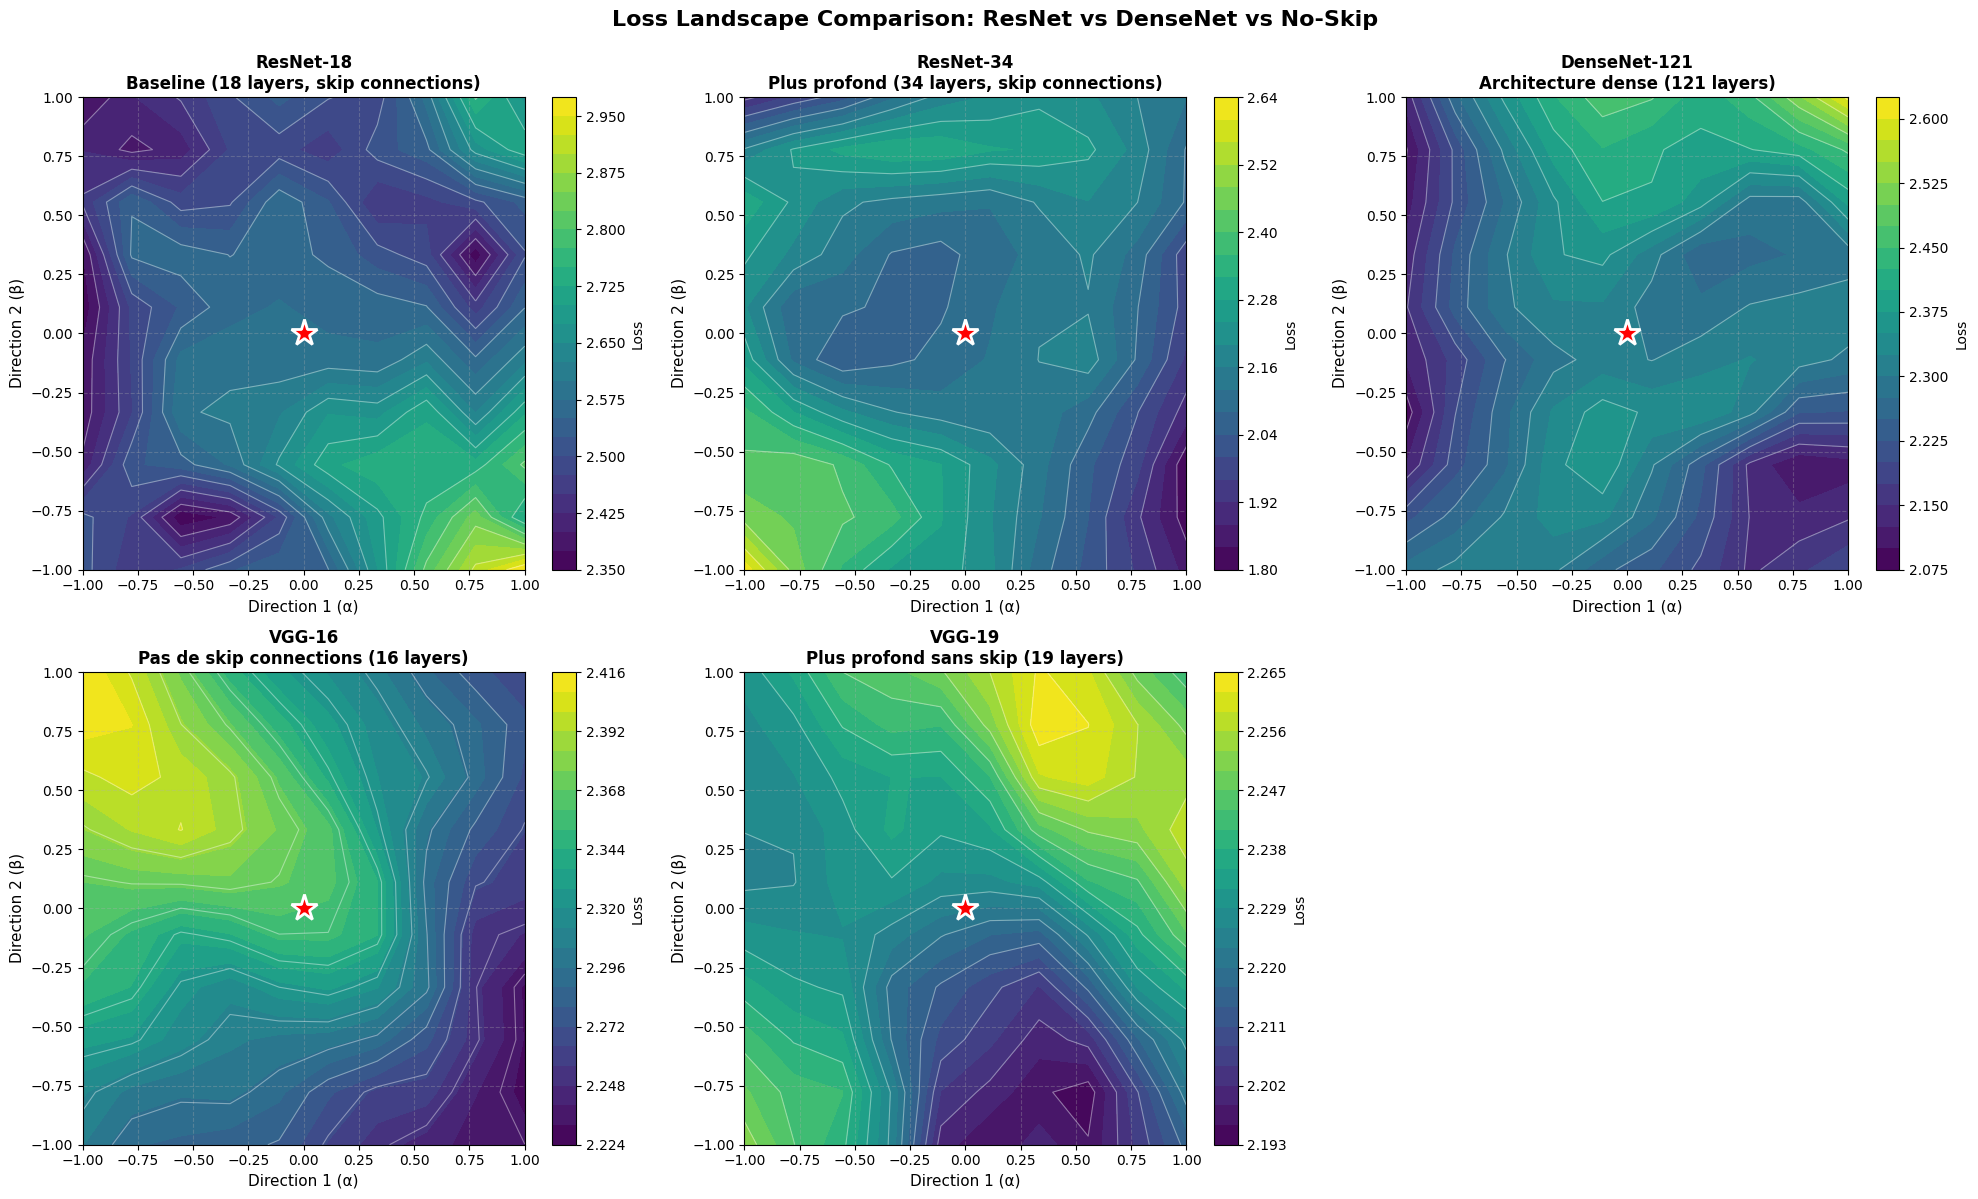

In [6]:
# Grille de visualisation: 2 lignes x 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (key, landscape) in enumerate(landscapes.items()):
    
    ax = axes[idx]
    config = model_configs[key]
    
    A, B = np.meshgrid(landscape['alphas'], landscape['betas'])
    
    # Contour plot
    contour = ax.contourf(A, B, landscape['losses'], levels=25, cmap='viridis')
    ax.contour(A, B, landscape['losses'], levels=12, colors='white', alpha=0.4, linewidths=0.8)
    
    # Point central
    ax.plot(0, 0, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2, zorder=10)
    
    # Labels
    ax.set_xlabel('Direction 1 (α)', fontsize=11)
    ax.set_ylabel('Direction 2 (β)', fontsize=11)
    ax.set_title(f"{config['name']}\n{config['description']}", 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Loss', fontsize=10)

# Cacher le dernier subplot vide
axes[-1].axis('off')

plt.suptitle('Loss Landscape Comparison: ResNet vs DenseNet vs No-Skip', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

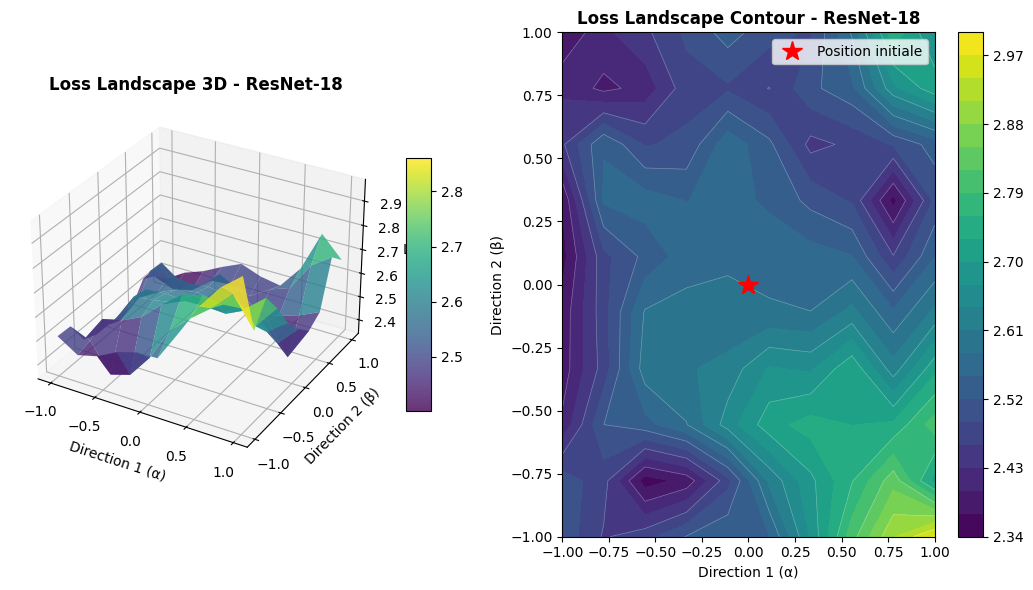

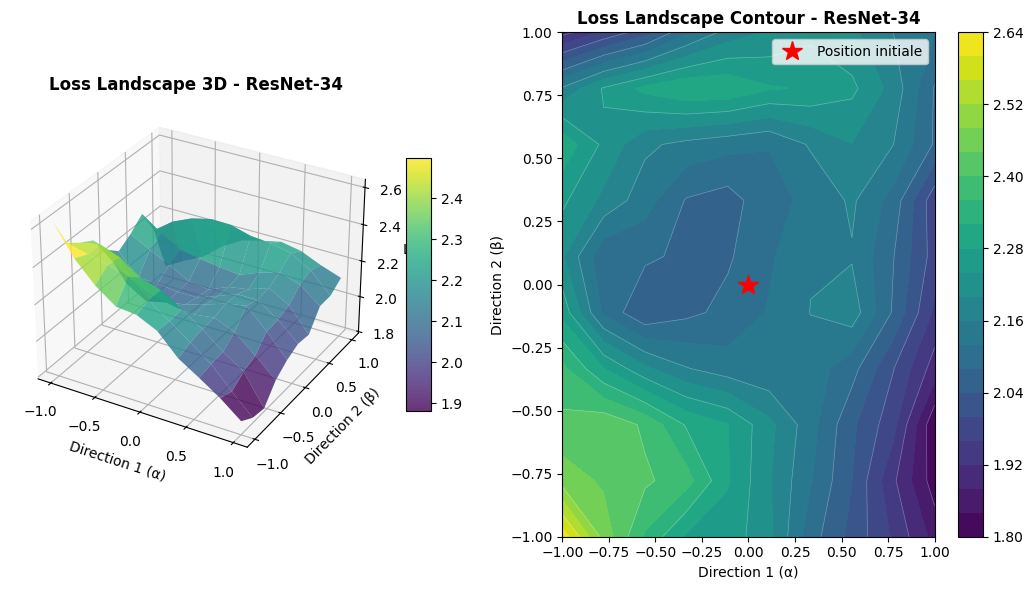

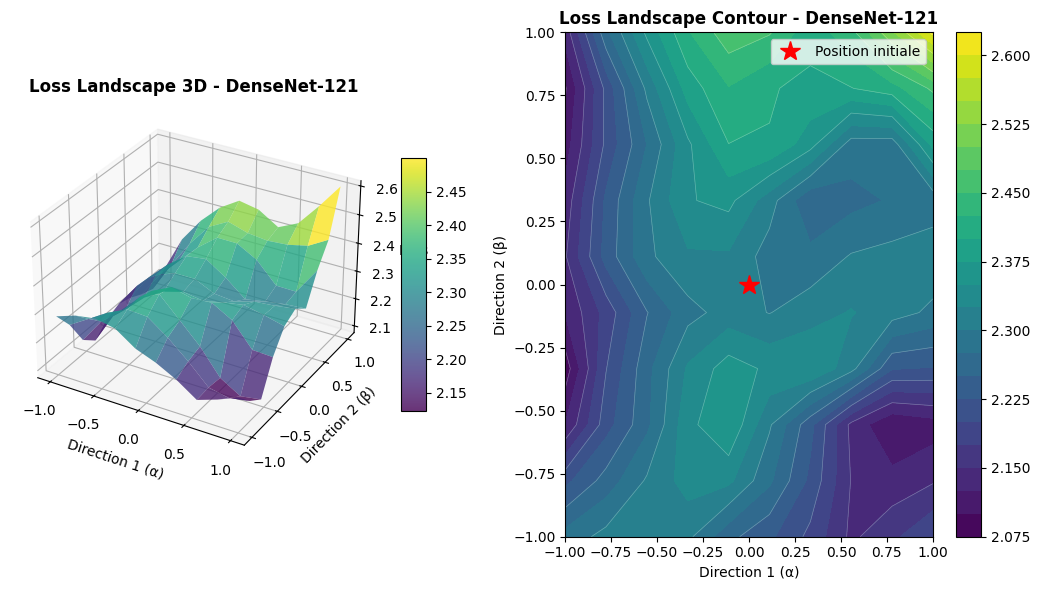

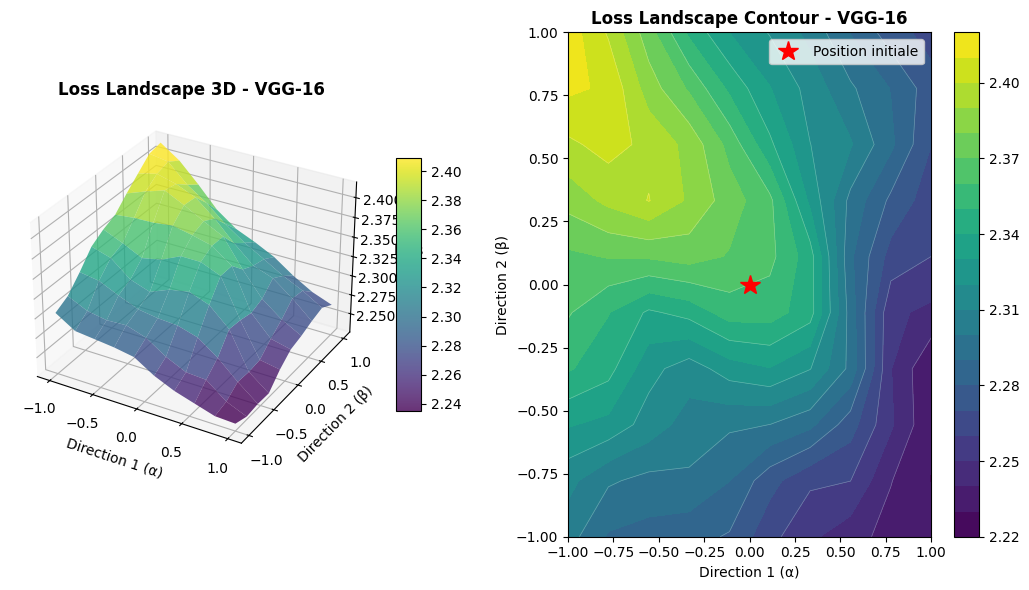

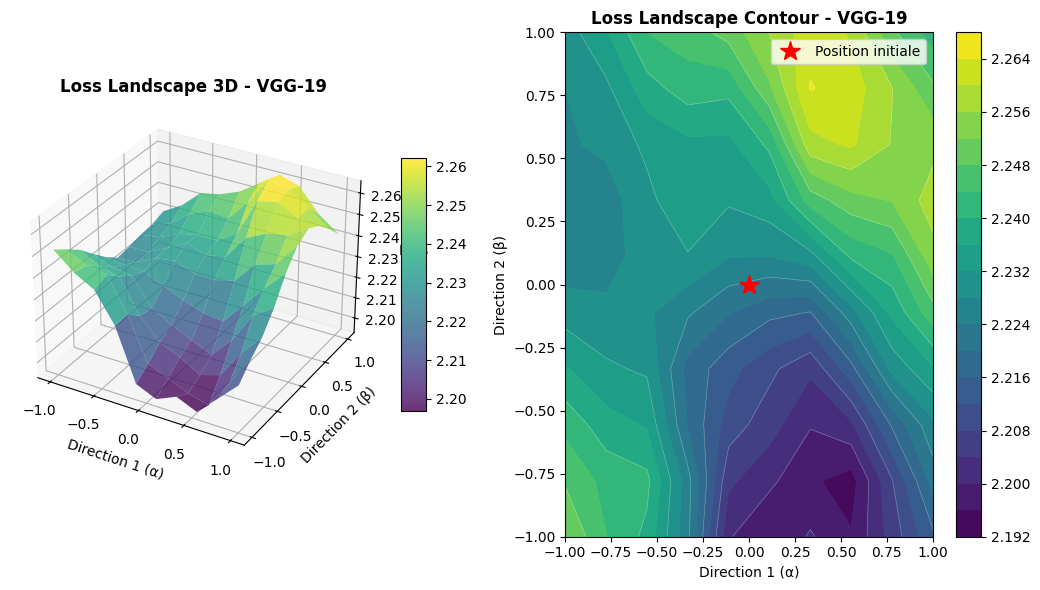

In [7]:
for idx, (key, landscape) in enumerate(landscapes.items()):
    config = model_configs[key]
    # Visualisation
    A, B = np.meshgrid(landscape['alphas'], landscape['betas'])

    fig = plt.figure(figsize=(16, 6))

    # Plot 3D surface
    ax1 = fig.add_subplot(131, projection='3d')
    surf = ax1.plot_surface(A, B, landscape['losses'], cmap='viridis', alpha=0.8, edgecolor='none')
    ax1.set_xlabel('Direction 1 (α)', fontsize=10)
    ax1.set_ylabel('Direction 2 (β)', fontsize=10)
    ax1.set_zlabel('Loss', fontsize=10)
    ax1.set_title(f'Loss Landscape 3D - {config["name"]}', fontsize=12, fontweight='bold')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10)

    # Plot 2D contour
    ax2 = fig.add_subplot(132)
    contour = ax2.contourf(A, B, landscape['losses'], levels=20, cmap='viridis')
    ax2.contour(A, B, landscape['losses'], levels=10, colors='white', alpha=0.3, linewidths=0.5)
    ax2.plot(0, 0, 'r*', markersize=15, label='Position initiale')
    ax2.set_xlabel('Direction 1 (α)', fontsize=10)
    ax2.set_ylabel('Direction 2 (β)', fontsize=10)
    ax2.set_title(f'Loss Landscape Contour - {config["name"]}', fontsize=12, fontweight='bold')
    ax2.legend()
    fig.colorbar(contour, ax=ax2)


    plt.tight_layout()
    plt.show()